In [1]:
%matplotlib inline
import sys, re
import numpy as np
from scipy.signal import medfilt, hilbert
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import statistics as sta

In [2]:
 # Chuẩn hóa data về 0,1 
def Normalize(data, min, max): 
    res = []    # Tạo LIST res rỗng để chứa kết quả
    t = max - min 
    for i in range(0, len(data)):   # Cho i chạy hết qua data
        if t == 0:
            res.append(0)
        else: 
            res.append((data[i]-min)/(max-min))  # Đẩy kết quả tính được bằng công thức vào danh sách 
    return res

In [3]:
# Tins F0mean và F0std 
def Cal_f0mean(f0list):
    b = []
    for i in range(len(f0list)):
        if f0list[i] != 0:
            b.append(f0list[i])
    f0mean = sta.mean(b)
    f0mean = int(round(1.0*f0mean)) # làm tròn giá trị F0mean
    return f0mean
def Cal_f0std(f0list):
    b = []
    for i in range(len(f0list)):
        if f0list[i] != 0:
             b.append(f0list[i])
    f0std = sta.pstdev(b)
    f0std = round(f0std,2)   # làm tròn F0 F0std
    return f0std

In [4]:
# Hàm tính tính F0 cho toàn bộ tín hiệu bằng AMDF 
def AMDF_FUNTION(f0list):
    diffoffset = np.int64(round(framelen/winoffsetdivisor)) 
    irange = range(0, signallen-2*framelen, framelen)  
    # Tạo mảng chưa danh sách F0 và danh sách chứa giá trị AMDF 
    meandiffs = np.zeros(framelen).tolist()  
    # Cho mỗi khung chạy dọc theo chiều dài tín hiệu 
    count = 0  # dùng để thể hiện chỉ số F0 trong F0list
    for framestart in irange:
        framestop = framestart + framelen   
        frame = signal[framestart:framestop]   # Lấy giá trị cho mỗi khung tín hiệu 
        # Tính Chênh lệch Độ lớn Trung bình với mỗi khung 
        indx = 0
        f0 = 0 
        for winstart in range(framestart,framestop):
            movingwin = signal[winstart:winstart+framelen]
            absdiffs = abs(frame - movingwin)
            meandiffs[indx] = np.mean(absdiffs)
            indx += 1 
        # chuẩn hóa AMDF
        meandiffs = Normalize(meandiffs, min(meandiffs), max(meandiffs))   
        # Chọn chênh lệch tuyệt đối nhỏ nhất trong khung hình với ngưỡng ứng với giá trị mẫu là diffoffset
        smallest = np.min(meandiffs[diffoffset:])
        # Lấy chỉ số mẫu của giá trị chênh lệch tuyệt đối nhỏ nhất nhỏ nhất vừa tìm được trong khung 
        index = meandiffs.index(smallest)
        # Tính F0
        if index != 0:
            f0 = fs / index   # f0 = 1/T0  mà T0 = index/fs =>  f0 = fs / index    (index là chỉ số mẫu)
        # Đẩy F0 vào danh sách F0list và tăng 
        f0list[count] = f0
        count += 1
        # Hoàn thành cho một khung tín hiệu# Hàm tính tính F0 cho toàn bộ tín hiệu bằng AMDF 


In [5]:
# Hàm xuất đồ thị đường F0  và đồ thị tín hiệu 
def graph(signal,f0list,f0mean,f0mean_cal): 
    # đồ thị F0 
    sp2figname = 'speech-F0-estimation-%s.png'%filebase
    
    # in và xuất ra đồ thị F0 
    fig, (sp1,sp2) = plt.subplots(2, 1, figsize=(16,4))
    signal = signal / float(np.max(abs(signal)))
    x = np.linspace(0,len(signal),len(signal))/fs
    sp1.plot(x,signal,color='lightblue')
    sp1.set_title('Singnal')
    sp1.set_xlabel('Time (s)')
    signalduration = float(len(signal))/fs
    sp1.set_xlim(0,signalduration)
    sp1.set_ylim(-1,1)
    sp1.plot(signal)
    
    sp2.set_title('AMDF (F0 estimation)',fontsize=22)
    sp2.set_xlabel('Time (s)')
    sp2.set_xlim(0,signalduration)
    #f0min , f0max
    sp2.set_ylim(70,300)
    y = f0list
    leny = len(y)
    x = np.linspace(0,leny,leny)*framerate
    sp2.scatter(x,y,s=5,color='b')
    plt.tight_layout(pad=1, w_pad=0.1, h_pad=0.1)
    #sp2.plot([f0mean,f0mean,f0mean,f0mean,f0mean,f0mean],"r--")
    #sp2.plot([f0mean_cal,f0mean_cal,f0mean_cal,f0mean_cal,f0mean_cal,f0mean_cal],"g--")

In [6]:
# Hàm xuất đồ thị  một khung tín hiệu và AMDF 
def a_frame_out(time,t): # time (s) 
    #framestart là chỉ số mẫu bắt đầu  
    diffoffset = np.int64(round(framelen/winoffsetdivisor)) 
    framestart =  int(round(1.0*time * fs ))  
    framestop = framestart + framelen   # kết thúc khung ở mẫu 
    frame = signal[framestart:framestop] # lấy giá trị cho khung từ signal
    
    #tính AMDf cho khung tín hiệu
    meandiffs = np.zeros(framelen).tolist()  
    indx = 0
    for winstart in range(framestart,framestop):
        movingwin = signal[winstart:winstart+framelen]
        absdiffs = abs(frame - movingwin)
        meandiffs[indx] =  np.mean(absdiffs)
        indx += 1 
    # chuẩn hóa AMDF
    f0 = 0 
    meandiffs = Normalize(meandiffs, min(meandiffs), max(meandiffs))   
    # Chọn chênh lệch tuyệt đối nhỏ nhất trong khung hình với ngưỡng ứng với giá trị mẫu là diffoffset
    smallest = np.min(meandiffs[diffoffset:])
    # Lấy chỉ số mẫu của giá trị chênh lệch tuyệt đối nhỏ nhất nhỏ nhất vừa tìm được trong khung 
    index = meandiffs.index(smallest)
    # Tính F0
    if index != 0:
        f0 = fs / index   # f0 = 1/T0  mà T0 = index/fs =>  f0 = fs / index    (index là chỉ số mẫu)  
    
    #  xuất ra các thông tin phục vụ đồ thị 
    k = meandiffs[diffoffset] 
    k = round(k,2)   
    h = meandiffs[index]
    h = round(h,2) 
    f0 = round(f0,2)
    print("Chỉ số mẫu để xác định ngưỡng:",diffoffset)
    print("Giá trị ngưỡng tại mẫu: ",k)
    print("Mẫu dip min tìm được :",index)   
    print("Giá trị của biên tại mẫu:",h)  
    print("F0:",f0)  
    
    # in đồ thị 
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
    fig.suptitle(t,fontsize=16)
    ax1.plot(frame)
    ax2.plot(meandiffs)
    ax1.set_title('Signal'); 
    ax2.set_title('AMDF')
    y = meandiffs[index]
    ax2.plot(index,meandiffs[index],"o",color = "red")
    ax1.set_xlabel('samples');  ax2.set_xlabel('samples');  # x label
    ax1.set_xlim(0, framelen) ;  ax2.set_xlim(0, framelen)
    ax2.plot([index,index,index,index,index],[0.0,0.4,0.6,0.8,1.0],'b--')
    ax2.plot([diffoffset,len(meandiffs)],[meandiffs[diffoffset],meandiffs[diffoffset]],'g--')
    #ax2.set_ylim(0,1)
    plt.tight_layout()
    plt.show()

In [7]:
# hàm chạy toàn bộ các hàm cần dùng cho 1 tín hiệu wav 
def f0estimation(): 
    # tạo list chứa F0 
    f0list = np.zeros(framecount)
    # chạy hàm AMDF cho toàn bộ tín hiệu 
    AMDF_FUNTION(f0list)
    # Xóa F0 ngoài vùng 70 - 400 
    f0list = (f0list > f0min).astype(int) * f0list
    f0list = (f0list < f0max).astype(int) * f0list
    #tính toán F0mean và F0std
    a = Cal_f0mean(f0list)
    b = Cal_f0std(f0list) 
    c = round(abs(f0mean-a),2)
    d =  round(abs(f0std-b),2)
    # in ra đồ thị và thông số cần thiết
    graph(signal,f0list,f0mean,a)
    print("F0 mean:",f0mean,"    F0 mean cal:", a,"      Độ lệch: ",c)
    print("F0 std :",f0std,"   F0 std cal: ", b,"    Độ lệch: ",d )

Tần số lấy mẫu:  16000
Chỉ số mẫu để xác định ngưỡng: 10
Giá trị ngưỡng tại mẫu:  0.46
Mẫu dip min tìm được : 127
Giá trị của biên tại mẫu: 0.22
F0: 125.98


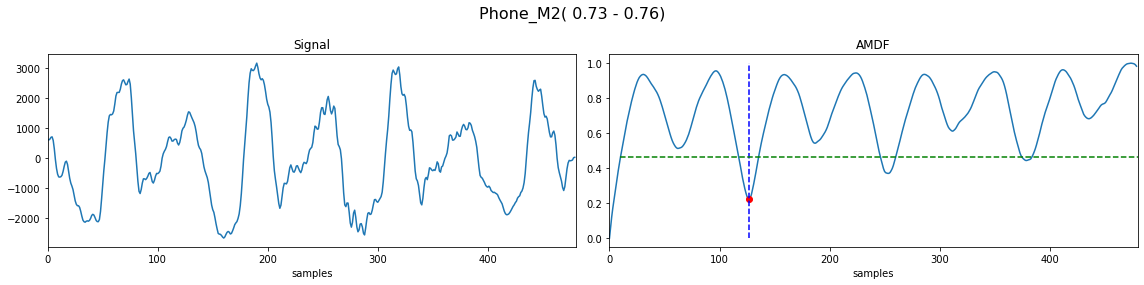

Chỉ số mẫu để xác định ngưỡng: 10
Giá trị ngưỡng tại mẫu:  0.82
Mẫu dip min tìm được : 67
Giá trị của biên tại mẫu: 0.63
F0: 238.81


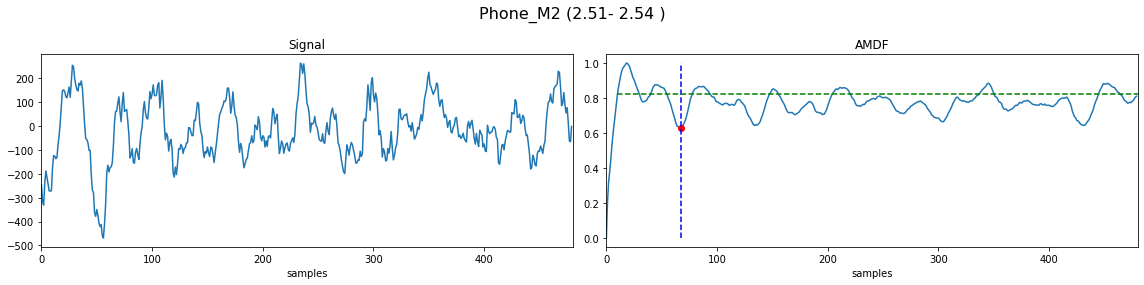

F0 mean: 129     F0 mean cal: 128       Độ lệch:  1
F0 std : 18.6    F0 std cal:  24.36     Độ lệch:  5.76


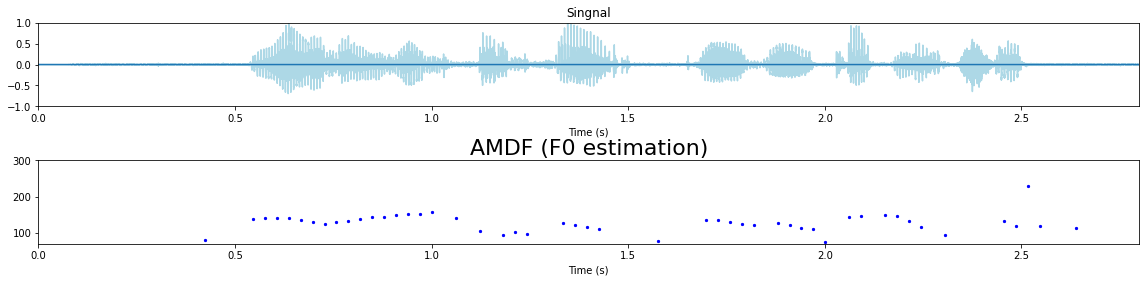

In [8]:
# INPUT: file wav 
fs, signal = wav.read('phone_M2.wav') 
filebase = 'studio_M2.wav'
print("Tần số lấy mẫu: ",fs)
#signal = signal/max(signal)
# Định nghĩa các tham số ban đầu 
# chỉ số này dùng để xác định ngưỡng trong mỗi khung tín hệu
framerate = 0.03
f0min = 70
f0max = 400
framelen = len(signal)
winoffsetdivisor = 50 # Lấy Chiều dài khung chia cho giá trị này ta được chỉ số mẫu để xác định ngưỡng 
signallen = len(signal)   
singal_duration_s = signallen/fs  # chiều dài tín hiệu tín bằng giây 
signalduration = int(round(1.0*signallen/fs))   # chiều dài tín hiệu tín bằng giây làm tròn dùng trong xuất độ thị
framelen = np.int64(round(fs * framerate))   # chiều dài tín hiệu tín bằng mẫu 
framecount = np.int64(round(1.0 * signallen / framelen))  # tổng số khung tín hiệu 
f0mean = 129
f0std  = 18.6
t = 'Phone_M2( 0.73 - 0.76)'
a_frame_out(0.73,t)
t = 'Phone_M2 (2.51- 2.54 )'
a_frame_out(2.51,t)
f0estimation()

Tần số lấy mẫu:  16000
Chỉ số mẫu để xác định ngưỡng: 10
Giá trị ngưỡng tại mẫu:  0.68
Mẫu dip min tìm được : 79
Giá trị của biên tại mẫu: 0.07
F0: 202.53


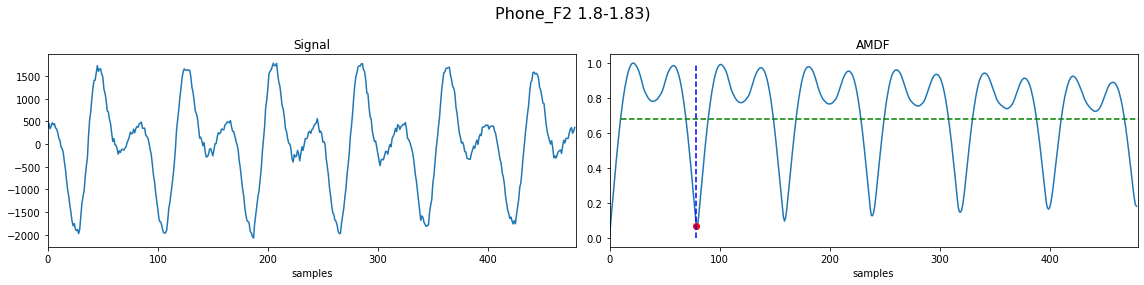

Chỉ số mẫu để xác định ngưỡng: 10
Giá trị ngưỡng tại mẫu:  0.65
Mẫu dip min tìm được : 10
Giá trị của biên tại mẫu: 0.65
F0: 1600.0


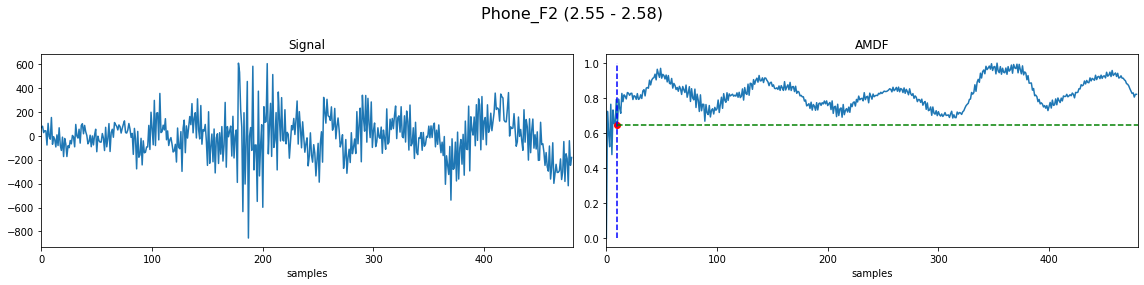

F0 mean: 145     F0 mean cal: 151       Độ lệch:  6
F0 std : 33.7    F0 std cal:  39.29     Độ lệch:  5.59


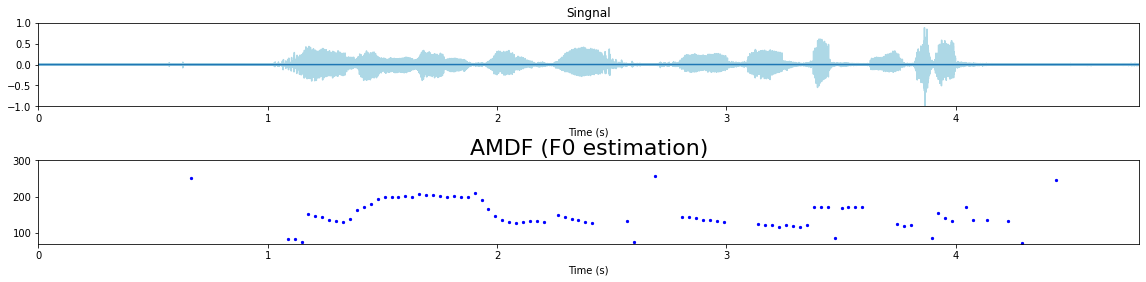

In [9]:
# INPUT: file wav 
fs, signal = wav.read('phone_F2.wav') 
filebase = 'studio_M1.wav' # tên dùng để xuất file ra ổ cứng
print("Tần số lấy mẫu: ",fs)
# Định nghĩa các tham số ban đầu 
# chỉ số này dùng để xác định ngưỡng trong mỗi khung tín hệu
framerate = 0.03 # độ dài khung tín hiệu tín bằng giây 
f0min = 70
f0max = 400
winoffsetdivisor = 50 # Lấy Chiều dài khung chia cho giá trị này ta được chỉ số mẫu để xác định ngưỡng 
signallen = len(signal)   
singal_duration_s = signallen/fs  # chiều dài tín hiệu tín bằng giây 
signalduration = int(round(1.0*signallen/fs))   # chiều dài tín hiệu tín bằng giây làm tròn dùng trong xuất độ thị
framelen = np.int64(round(fs * framerate))   # chiều dài tín hiệu tín bằng mẫu 
framecount = np.int64(round(1.0 * signallen / framelen))  # tổng số khung tín hiệu 
f0mean = 145
f0std  = 33.7
t = 'Phone_F2 1.8-1.83)'
a_frame_out(1.8,t)
t = 'Phone_F2 (2.55 - 2.58)'
a_frame_out(2.70,t)
f0estimation()

C:\Users\CHIENH~1\AppData\Local\Temp/ipykernel_8612/335372719.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wav.read('studio_M2.wav')


Tần số lấy mẫu:  44100
1323
Chỉ số mẫu để xác định ngưỡng: 26
Giá trị ngưỡng tại mẫu:  0.61
Mẫu dip min tìm được : 265
Giá trị của biên tại mẫu: 0.34
F0: 166.42


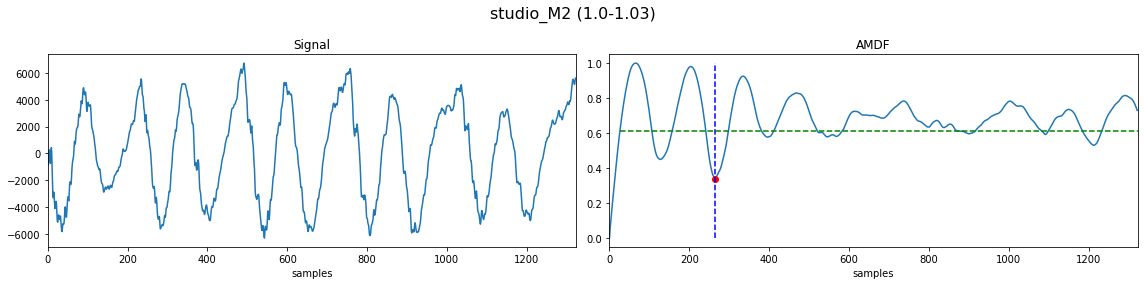

Chỉ số mẫu để xác định ngưỡng: 26
Giá trị ngưỡng tại mẫu:  0.05
Mẫu dip min tìm được : 27
Giá trị của biên tại mẫu: 0.05
F0: 1633.33


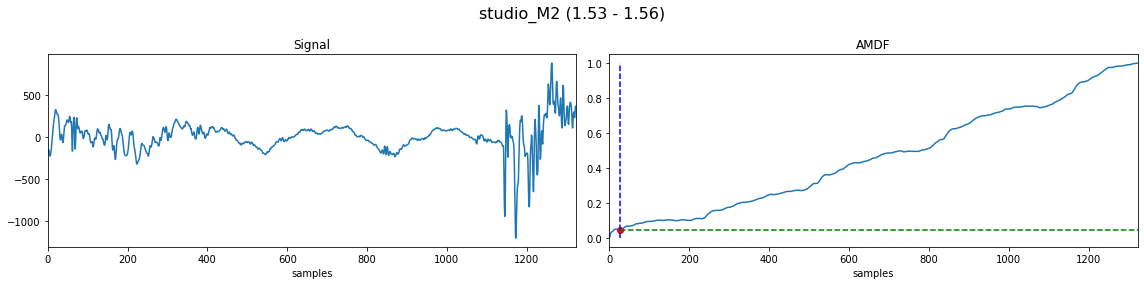

Chỉ số mẫu để xác định ngưỡng: 26
Giá trị ngưỡng tại mẫu:  0.43
Mẫu dip min tìm được : 26
Giá trị của biên tại mẫu: 0.43
F0: 1696.15


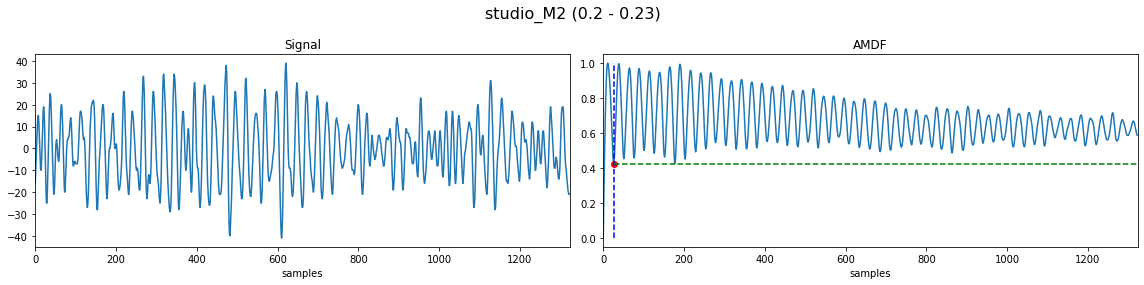

F0 mean: 155     F0 mean cal: 158       Độ lệch:  3
F0 std : 30.8    F0 std cal:  34.74     Độ lệch:  3.94


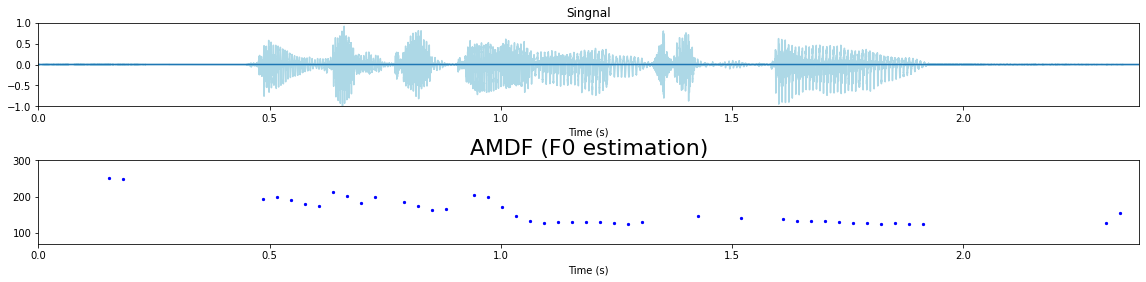

In [10]:
# INPUT: file wav 
fs, signal = wav.read('studio_M2.wav') 
print("Tần số lấy mẫu: ",fs)
filebase = 'studio_M1.wav' # tên dùng để xuất file ra ổ cứng
# Định nghĩa các tham số ban đầu 
# chỉ số này dùng để xác định ngưỡng trong mỗi khung tín hệu
framerate = 0.03 # độ dài khung tín hiệu tín bằng giây 
f0min = 70
f0max = 400
framelen = len(signal)
winoffsetdivisor = 50 # Lấy Chiều dài khung chia cho giá trị này ta được chỉ số mẫu để xác định ngưỡng 
signallen = len(signal)   
singal_duration_s = signallen/fs  # chiều dài tín hiệu tín bằng giây 
signalduration = int(round(1.0*signallen/fs))   # chiều dài tín hiệu tín bằng giây làm tròn dùng trong xuất độ thị
framelen = np.int64(round(fs * framerate))   # chiều dài tín hiệu tín bằng mẫu 
framecount = np.int64(round(1.0 * signallen / framelen))  # tổng số khung tín hiệu 
print(framelen)
f0mean = 155
f0std  = 30.8
t = 'studio_M2 (1.0-1.03)'
a_frame_out(1,t)
t = 'studio_M2 (1.53 - 1.56)'
a_frame_out(1.56,t)
t = 'studio_M2 (0.2 - 0.23)'
a_frame_out(0.2,t)
f0estimation()

Tần số lấy mẫu:  44100
Chỉ số mẫu để xác định ngưỡng: 26
Giá trị ngưỡng tại mẫu:  0.36
Mẫu dip min tìm được : 213
Giá trị của biên tại mẫu: 0.04
F0: 207.04


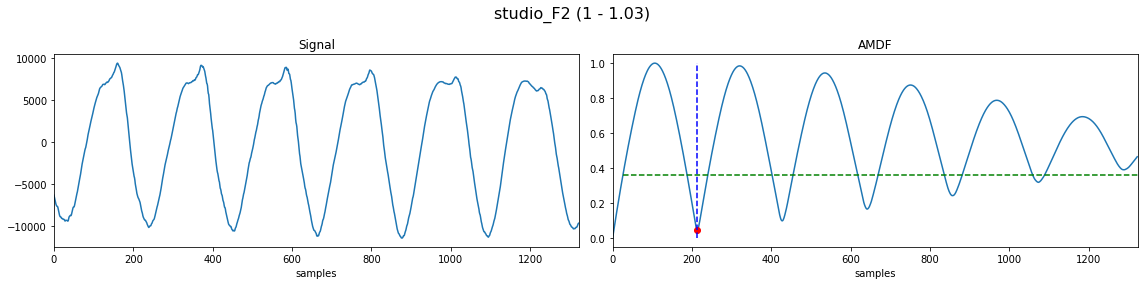

Chỉ số mẫu để xác định ngưỡng: 26
Giá trị ngưỡng tại mẫu:  0.13
Mẫu dip min tìm được : 413
Giá trị của biên tại mẫu: 0.09
F0: 106.78


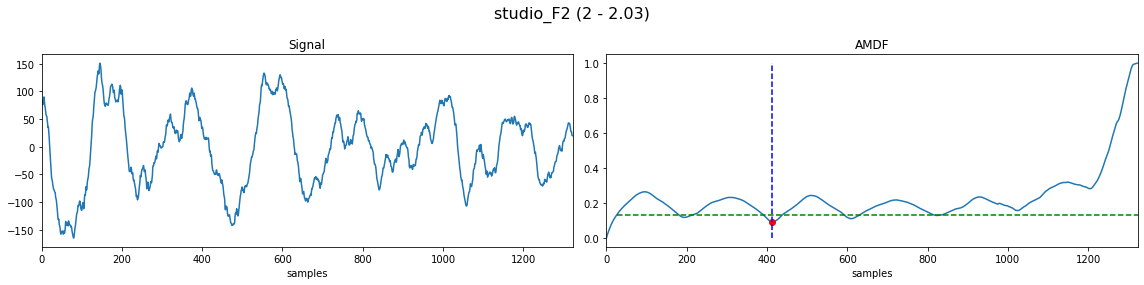

F0 mean: 200     F0 mean cal: 195       Độ lệch:  5
F0 std : 46.1    F0 std cal:  52.59     Độ lệch:  6.49


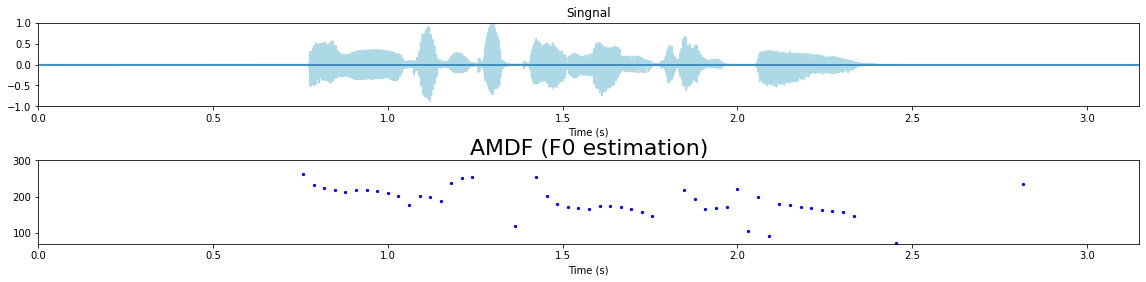

In [11]:
# INPUT: file wav 
fs, signal = wav.read('studio_F2.wav') 
print("Tần số lấy mẫu: ",fs)
filebase = 'phone_F1.wav' # tên dùng để xuất file ra ổ cứng
# Định nghĩa các tham số ban đầu 
# chỉ số này dùng để xác định ngưỡng trong mỗi khung tín hệu
framerate = 0.03 # độ dài khung tín hiệu tín bằng giây 
f0min = 70
f0max = 400
framelen = len(signal)
winoffsetdivisor = 50 # Lấy Chiều dài khung chia cho giá trị này ta được chỉ số mẫu để xác định ngưỡng 
signallen = len(signal)   
singal_duration_s = signallen/fs  # chiều dài tín hiệu tín bằng giây 
signalduration = int(round(1.0*signallen/fs))   # chiều dài tín hiệu tín bằng giây làm tròn dùng trong xuất độ thị
framelen = np.int64(round(fs * framerate))   # chiều dài tín hiệu tín bằng mẫu 
framecount = np.int64(round(1.0 * signallen / framelen))  # tổng số khung tín hiệu 
f0mean = 200
f0std  = 46.1
t = 'studio_F2 (1 - 1.03)'
a_frame_out(1,t)
t = 'studio_F2 (2 - 2.03)'
a_frame_out(2.0,t)
f0estimation()